# Setup and Installation

In [1]:
!pip -q install --upgrade --no-warn-script-location ultralytics albumentations pycocotools torchmetrics tqdm

import os, json, shutil, random, warnings
from pathlib import Path
from ultralytics import YOLO
import yaml, torch, numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pandas as pd
import csv
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 fi

# Model Loading and Dataset Path Setup

In [2]:
# Load YOLOv11 model (using yolo11n.pt instead of yolov10n.pt)
model = YOLO("yolo11n.pt")
print("✅ YOLOv11 loaded successfully")

DATA_ROOT = Path("/kaggle/input/assignment-mango/mango")
print(f"✅ Using dataset path: {DATA_ROOT}")

if not DATA_ROOT.exists():
    print("❌ Dataset path not found!")
    for item in Path("/kaggle/input").rglob("*mango*"):
        if item.is_dir():
            print(f"Found mango dir: {item}")
else:
    print("✅ Dataset found!")

CLASSES = ["Early-Fruit","Mature","Premature","Ripe"]
name2id = {n:i for i,n in enumerate(CLASSES)}

✅ YOLOv11 loaded successfully
✅ Using dataset path: /kaggle/input/assignment-mango/mango
✅ Dataset found!


# Annotation File Detection and Mapping

In [3]:
print(f"\n🔍 Looking for annotation files in: {DATA_ROOT}")

COCO_ANN = {}

# FIXED: More comprehensive annotation file detection
print("🔍 Searching for annotation files...")

# Method 1: Check Annotation directory
ann_dir = DATA_ROOT / "Annotation"
if ann_dir.exists():
    print(f"✅ Annotation directory found: {ann_dir}")
    for json_file in ann_dir.rglob("*.json"):
        print(f"Found JSON in Annotation: {json_file}")

# Method 2: Check all class-specific COCO directories  
class_dirs = ["Early-Fruit_COCO", "Mature_COCO", "Premature_COCO", "Ripe_COCO"]
for class_dir in class_dirs:
    dir_path = DATA_ROOT / class_dir
    if dir_path.exists():
        for json_file in dir_path.rglob("*.json"):
            print(f"Found JSON in {class_dir}: {json_file}")

# Method 3: Search entire dataset for JSON files
print("🔍 Comprehensive JSON file search:")
all_json_files = list(DATA_ROOT.rglob("*.json"))
print(f"Found {len(all_json_files)} JSON files total:")
for json_file in all_json_files:
    print(f"  📄 {json_file}")


🔍 Looking for annotation files in: /kaggle/input/assignment-mango/mango
🔍 Searching for annotation files...
✅ Annotation directory found: /kaggle/input/assignment-mango/mango/Annotation
Found JSON in Annotation: /kaggle/input/assignment-mango/mango/Annotation/Mature/_annotations.coco.json
Found JSON in Annotation: /kaggle/input/assignment-mango/mango/Annotation/Early-fruit/_annotations.coco.json
Found JSON in Annotation: /kaggle/input/assignment-mango/mango/Annotation/Premature/_annotations.coco.json
Found JSON in Annotation: /kaggle/input/assignment-mango/mango/Annotation/Ripe/_annotations.coco.json
🔍 Comprehensive JSON file search:
Found 4 JSON files total:
  📄 /kaggle/input/assignment-mango/mango/Annotation/Mature/_annotations.coco.json
  📄 /kaggle/input/assignment-mango/mango/Annotation/Early-fruit/_annotations.coco.json
  📄 /kaggle/input/assignment-mango/mango/Annotation/Premature/_annotations.coco.json
  📄 /kaggle/input/assignment-mango/mango/Annotation/Ripe/_annotations.coco.js

# Advanced Annotation File Mapping

In [4]:
# FIXED: Improved annotation file mapping with multiple search strategies
annotation_mappings = {
    "Early-Fruit": ["early", "Early-Fruit", "early-fruit", "earlyfruit"],
    "Mature": ["mature", "Mature"],
    "Premature": ["premature", "Premature", "pre-mature", "prematur"],
    "Ripe": ["ripe", "Ripe"]
}

# Strategy 1: Direct folder mapping
direct_mapping = {
    "Early-Fruit_COCO": "Early-Fruit",
    "Mature_COCO": "Mature", 
    "Premature_COCO": "Premature",
    "Ripe_COCO": "Ripe"
}

for folder_name, class_name in direct_mapping.items():
    folder_path = DATA_ROOT / folder_name
    if folder_path.exists():
        json_files = list(folder_path.glob("*.json"))
        if json_files:
            COCO_ANN[class_name] = json_files[0]
            print(f"✅ Direct mapping - {class_name}: {json_files[0]}")

# Strategy 2: Filename/path based search for missing classes
for class_name, search_terms in annotation_mappings.items():
    if class_name not in COCO_ANN:  # Only search if not found yet
        found = False
        for json_file in all_json_files:
            file_str = str(json_file).lower()
            if any(term.lower() in file_str for term in search_terms):
                COCO_ANN[class_name] = json_file
                print(f"✅ Search mapping - {class_name}: {json_file}")
                found = True
                break
        
        if not found:
            print(f"❌ Could not find annotation for {class_name}")

print(f"📋 Final annotation mapping: {COCO_ANN}")
print(f"📊 Found {len(COCO_ANN)}/{len(CLASSES)} annotation files")

✅ Search mapping - Early-Fruit: /kaggle/input/assignment-mango/mango/Annotation/Early-fruit/_annotations.coco.json
✅ Search mapping - Mature: /kaggle/input/assignment-mango/mango/Annotation/Mature/_annotations.coco.json
✅ Search mapping - Premature: /kaggle/input/assignment-mango/mango/Annotation/Premature/_annotations.coco.json
✅ Search mapping - Ripe: /kaggle/input/assignment-mango/mango/Annotation/Ripe/_annotations.coco.json
📋 Final annotation mapping: {'Early-Fruit': PosixPath('/kaggle/input/assignment-mango/mango/Annotation/Early-fruit/_annotations.coco.json'), 'Mature': PosixPath('/kaggle/input/assignment-mango/mango/Annotation/Mature/_annotations.coco.json'), 'Premature': PosixPath('/kaggle/input/assignment-mango/mango/Annotation/Premature/_annotations.coco.json'), 'Ripe': PosixPath('/kaggle/input/assignment-mango/mango/Annotation/Ripe/_annotations.coco.json')}
📊 Found 4/4 annotation files


# Annotation File Content Verification

In [5]:
# ADDED: Verify annotation file contents
print("\n🔍 Verifying annotation file contents:")
for class_name, ann_path in COCO_ANN.items():
    if ann_path and ann_path.exists():
        try:
            with open(ann_path, "r") as f:
                data = json.load(f)
            images_count = len(data.get("images", []))
            annotations_count = len(data.get("annotations", []))
            print(f"✅ {class_name}: {images_count} images, {annotations_count} annotations")
        except Exception as e:
            print(f"❌ Error reading {class_name}: {e}")
    else:
        print(f"❌ {class_name}: File not found or invalid")


🔍 Verifying annotation file contents:
✅ Early-Fruit: 468 images, 820 annotations
✅ Mature: 514 images, 890 annotations
✅ Premature: 526 images, 910 annotations
✅ Ripe: 496 images, 554 annotations


# Image Directory Setup and Verification 

In [6]:
# Image directory setup
print(f"\n🔍 Looking for image directories...")
IMG_DIRS = [
    DATA_ROOT/"Early-Fruit_COCO",
    DATA_ROOT/"Mature_COCO",
    DATA_ROOT/"Premature_COCO",
    DATA_ROOT/"Ripe_COCO",
    DATA_ROOT/"Annotation"
]

verified_dirs = []
for img_dir in IMG_DIRS:
    if img_dir.exists():
        img_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
        img_count = 0
        for ext in img_extensions:
            img_count += len(list(img_dir.glob(ext)))

        if img_count > 0:
            print(f"✅ {img_dir.name}: {img_count} images")
            verified_dirs.append(img_dir)
        else:
            print(f"🔍 {img_dir.name}: directory exists but no images")
    else:
        print(f"❌ {img_dir.name}: directory not found")

IMG_DIRS = verified_dirs
print(f"📂 Using {len(IMG_DIRS)} image directories with images")


🔍 Looking for image directories...
✅ Early-Fruit_COCO: 468 images
✅ Mature_COCO: 514 images
✅ Premature_COCO: 526 images
✅ Ripe_COCO: 496 images
🔍 Annotation: directory exists but no images
📂 Using 4 image directories with images


# Utility Functions for Data Processing

In [7]:
def find_image_path(filename):
    for d in IMG_DIRS:
        p = d/filename
        if p.exists():
            return p
        cand = list(d.rglob(filename))
        if cand:
            return cand[0]
    return None

def coco_to_yolo_line(size_wh, bbox_xywh):
    W, H = size_wh
    x,y,w,h = bbox_xywh
    cx = (x + w/2)/W
    cy = (y + h/2)/H
    return cx, cy, w/W, h/H

#  COCO to YOLO Format Conversion

In [8]:
def parse_and_merge_coco():
    merged = defaultdict(list)
    imgmeta = {}
    problems = []
    class_counts = defaultdict(int)  # Track annotations per class

    print("\n🔄 Processing COCO annotations...")
    
    for cname, ann_path in COCO_ANN.items():
        if not ann_path or not ann_path.exists():
            problems.append(f"Missing JSON: {ann_path}")
            continue
            
        cls_id = name2id[cname]
        print(f"🔍 Processing {cname} (class_id={cls_id}) from {ann_path}")

        try:
            with open(ann_path, "r") as f:
                d = json.load(f)
        except Exception as e:
            problems.append(f"Error reading {ann_path}: {e}")
            continue

        images = d.get("images", [])
        annotations = d.get("annotations", [])
        print(f"   📊 {len(images)} images, {len(annotations)} annotations in JSON")

        id2img = {im["id"]: im for im in images}
        
        processed_annotations = 0
        for ann in annotations:
            class_counts[cname] += 1
            im = id2img.get(ann["image_id"])
            if im is None:
                continue

            filename = im["file_name"]
            W, H = im["width"], im["height"]
            img_path = find_image_path(filename)
            if img_path is None:
                problems.append(f"Image not found: {filename}")
                continue

            cx, cy, ww, hh = coco_to_yolo_line((W, H), ann["bbox"])
            stem = Path(filename).stem
            merged[stem].append((cls_id, cx, cy, ww, hh))
            imgmeta[stem] = (filename, W, H, cname)
            processed_annotations += 1
            
        print(f"   ✅ {cname}: Processed {processed_annotations} annotations")

    print(f"📈 Total annotation counts per class: {dict(class_counts)}")
    print(f"📊 Images with metadata: {len(imgmeta)}")
    print(f"📊 Images with bounding boxes: {len(merged)}")
    
    return merged, imgmeta, problems

merged, imgmeta, problems = parse_and_merge_coco()
print("Images indexed:", len(imgmeta), "| With boxes:", len(merged))
if problems:
    print(f"⚠️ Found {len(problems)} issues:")
    for p in problems[:20]:  # Show first 20 issues
        print(" -", p)


🔄 Processing COCO annotations...
🔍 Processing Early-Fruit (class_id=0) from /kaggle/input/assignment-mango/mango/Annotation/Early-fruit/_annotations.coco.json
   📊 468 images, 820 annotations in JSON
   ✅ Early-Fruit: Processed 820 annotations
🔍 Processing Mature (class_id=1) from /kaggle/input/assignment-mango/mango/Annotation/Mature/_annotations.coco.json
   📊 514 images, 890 annotations in JSON
   ✅ Mature: Processed 890 annotations
🔍 Processing Premature (class_id=2) from /kaggle/input/assignment-mango/mango/Annotation/Premature/_annotations.coco.json
   📊 526 images, 910 annotations in JSON
   ✅ Premature: Processed 910 annotations
🔍 Processing Ripe (class_id=3) from /kaggle/input/assignment-mango/mango/Annotation/Ripe/_annotations.coco.json
   📊 496 images, 554 annotations in JSON
   ✅ Ripe: Processed 554 annotations
📈 Total annotation counts per class: {'Early-Fruit': 820, 'Mature': 890, 'Premature': 910, 'Ripe': 554}
📊 Images with metadata: 2000
📊 Images with bounding boxes: 2

# Data Distribution Verification

In [9]:
# ADDED: Verify we have all 4 classes in the merged data
print("\n🔍 Verifying class distribution in processed data:")
class_distribution = defaultdict(int)
total_boxes = 0
for stem, boxes in merged.items():
    for cls_id, cx, cy, w, h in boxes:
        if cls_id < len(CLASSES):
            class_distribution[CLASSES[cls_id]] += 1
            total_boxes += 1

print(f"📊 Bounding box distribution:")
for class_name in CLASSES:
    count = class_distribution[class_name]
    percentage = (count/total_boxes*100) if total_boxes > 0 else 0
    print(f"   • {class_name}: {count} boxes ({percentage:.1f}%)")
print(f"   • Total: {total_boxes} boxes")


🔍 Verifying class distribution in processed data:
📊 Bounding box distribution:
   • Early-Fruit: 820 boxes (25.8%)
   • Mature: 890 boxes (28.0%)
   • Premature: 910 boxes (28.7%)
   • Ripe: 554 boxes (17.5%)
   • Total: 3174 boxes


#  Dataset Directory Creation

In [10]:
SPLIT = Path("/kaggle/working/dataset")

for s in ["train", "val", "test"]:
    (SPLIT/f"images/{s}").mkdir(parents=True, exist_ok=True)
    (SPLIT/f"labels/{s}").mkdir(parents=True, exist_ok=True)

# Data Preparation for Splitting

In [11]:
rows = []
for stem, (filename, W, H, cname) in imgmeta.items():
    if stem not in merged or len(merged[stem]) == 0:
        continue
    p = find_image_path(filename)
    if p is None:
        continue
    rows.append((stem, p, cname))

assert len(rows) > 0, "No images with boxes found."

stems  = np.array([r[0] for r in rows])
paths  = np.array([r[1] for r in rows])
labels = np.array([r[2] for r in rows])

#  Train/Val/Test Split (80/10/10)


In [12]:
# 80/10/10 split
train_idx, rest_idx = train_test_split(
    np.arange(len(rows)), test_size=0.20, stratify=labels, random_state=42
)
rest_labels = labels[rest_idx]
val_idx, test_idx = train_test_split(
    rest_idx, test_size=0.50, stratify=rest_labels, random_state=42
)

def subset_from_index(idxs):
    return [(paths[i], stems[i]) for i in idxs]

train_set = subset_from_index(train_idx)
val_set   = subset_from_index(val_idx)
test_set  = subset_from_index(test_idx)

print(f"Total usable: {len(rows)} | train={len(train_set)} val={len(val_set)} test={len(test_set)}")

Total usable: 2000 | train=1600 val=200 test=200


# Semi-Supervised Learning Split (20% Labeled)

In [13]:
# 20% labeled within train for SSL
train_labels = labels[train_idx]
t_lab_idx, t_unlab_idx = train_test_split(
    np.arange(len(train_idx)), test_size=0.80, stratify=train_labels, random_state=42
)

train_labeled   = [train_set[i] for i in t_lab_idx]
train_unlabeled = [train_set[i] for i in t_unlab_idx]

print(f"Train split: labeled={len(train_labeled)} ({len(train_labeled)/len(train_set):.1%}) "
      f"| unlabeled={len(train_unlabeled)} ({len(train_unlabeled)/len(train_set):.1%})")

Train split: labeled=320 (20.0%) | unlabeled=1280 (80.0%)


#  Data Copying Function with Validation

In [14]:
def copy_split_safe(pairs, split):
    (SPLIT/f"images/{split}").mkdir(parents=True, exist_ok=True)
    (SPLIT/f"labels/{split}").mkdir(parents=True, exist_ok=True)

    dropped = 0
    for img_path, stem in pairs:
        dst_im = SPLIT/f"images/{split}/{img_path.name}"
        shutil.copy(img_path, dst_im)

        lbs = merged.get(stem, [])
        lines = []
        for c, cx, cy, w, h in lbs:
            if w <= 0 or h <= 0:
                dropped += 1
                continue
            cx2 = min(1.0, max(0.0, cx))
            cy2 = min(1.0, max(0.0, cy))
            w2  = min(1.0, max(0.0, w))
            h2  = min(1.0, max(0.0, h))
            if w2 == 0 or h2 == 0:
                dropped += 1
                continue
            lines.append(f"{c} {cx2:.6f} {cy2:.6f} {w2:.6f} {h2:.6f}")

        with open(SPLIT/f"labels/{split}/{stem}.txt", "w") as f:
            f.write("\n".join(lines))

    if dropped:
        print(f"[{split}] dropped {dropped} degenerate/empty boxes.")

# Execute Data Copying and Save CSV Files

In [15]:
# Copy data to splits
copy_split_safe(train_set, "train")
copy_split_safe(val_set,   "val")
copy_split_safe(test_set,  "test")

with open("/kaggle/working/train_labeled.csv","w",newline="") as f:
    w=csv.writer(f); w.writerow(["img_path","stem"])
    w.writerows([(str(p), s) for p,s in train_labeled])

with open("/kaggle/working/train_unlabeled.csv","w",newline="") as f:
    w=csv.writer(f); w.writerow(["img_path","stem"])
    w.writerows([(str(p), s) for p,s in train_unlabeled])

print("Wrote /kaggle/working/train_labeled.csv and train_unlabeled.csv")

Wrote /kaggle/working/train_labeled.csv and train_unlabeled.csv


# YOLO Configuration File Generation

In [16]:
NC = len(CLASSES)
DATA_YAML_PATH = Path("/kaggle/working/mango_yolo/data.yaml")
DATA_YAML_PATH.parent.mkdir(parents=True, exist_ok=True)

data_yaml = f"""# auto-generated
path: {SPLIT}
train: images/train
val: images/val
test: images/test
nc: {NC}
names: {CLASSES}
"""

DATA_YAML_PATH.write_text(data_yaml, encoding="utf-8")
print("✅ Wrote data.yaml to:", DATA_YAML_PATH)

# ADDED: Verify the generated data.yaml content
print("\n📄 Generated data.yaml content:")
print(data_yaml)

✅ Wrote data.yaml to: /kaggle/working/mango_yolo/data.yaml

📄 Generated data.yaml content:
# auto-generated
path: /kaggle/working/dataset
train: images/train
val: images/val
test: images/test
nc: 4
names: ['Early-Fruit', 'Mature', 'Premature', 'Ripe']



# STAC Directory Setup

In [17]:
WORK = Path("/kaggle/working/stac_mango")
PSEUDO = WORK/"pseudo"
STU_ROOT = WORK/"student"

# Create STAC directories
for split in ["train", "val"]:
    (STU_ROOT/split/"images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT/split/"labels").mkdir(parents=True, exist_ok=True)
(PSEUDO/"labels").mkdir(parents=True, exist_ok=True)

# Load splits
train_labeled_df = pd.read_csv("/kaggle/working/train_labeled.csv")
train_unlabeled_df = pd.read_csv("/kaggle/working/train_unlabeled.csv")

print(f"✅ STAC setup complete")
print(f"Labeled: {len(train_labeled_df)} | Unlabeled: {len(train_unlabeled_df)}")

✅ STAC setup complete
Labeled: 320 | Unlabeled: 1280


#  Initial Teacher Model Training

In [18]:
print("\n🎯 Training initial teacher with YOLOv11 using EXACT specified parameters...")

# EXACT PARAMETERS AS SPECIFIED:
# LR: 1e-3, Batch: 16, Epochs: 50, Aug: mosaic+mixup, Conf: 0.25, IoU: 0.6

teacher = YOLO("yolo11n.pt")  # ✅ Changed to YOLOv11

teacher_results = teacher.train(
    data    = str(DATA_YAML_PATH),
    epochs  = 50,          # ✅ Epochs: 50 (as specified)
    imgsz   = 640,
    batch   = 16,          # ✅ Batch: 16 (as specified)
    lr0     = 1e-3,        # ✅ LR: 1e-3 (as specified)
    project = str(WORK),
    name    = "teacher_initial",
    device  = 0,
    mosaic  = 1.0,         # ✅ Mosaic augmentation (as specified)
    mixup   = 0.15,        # ✅ Mixup augmentation (as specified)
    conf    = 0.25,        # ✅ Confidence: 0.25 (as specified)
    iou     = 0.6          # ✅ IoU: 0.6 (as specified)
)

teacher_weights = WORK/"teacher_initial"/"weights"/"best.pt"
print(f"✅ Initial teacher trained with YOLOv11. Weights: {teacher_weights}")


🎯 Training initial teacher with YOLOv11 using EXACT specified parameters...
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mango_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.6, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_initial, nbs=64, nms=False, opset=None, optimize=

# Validation Data Setup and Teacher Verification

In [19]:
for img in (SPLIT/"images"/"val").iterdir():
    shutil.copy(img, STU_ROOT/"val"/"images"/img.name)

for lbl in (SPLIT/"labels"/"val").iterdir():
    shutil.copy(lbl, STU_ROOT/"val"/"labels"/lbl.name)

print(f"✅ Copied validation data to student directory")

# Verify teacher model loads correctly
if teacher_weights.exists():
    print(f"✅ Found teacher weights: {teacher_weights}")
    try:
        test_model = YOLO(str(teacher_weights))
        print(f"✅ Successfully loaded YOLOv11 teacher model!")
        
        # ADDED: Test the teacher model on validation to verify it can see all 4 classes
        print("🧪 Testing teacher model on validation set...")
        val_results = test_model.val(data=str(DATA_YAML_PATH), device=0)
        print(f"✅ Teacher validation completed!")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
else:
    print(f"❌ Teacher weights not found: {teacher_weights}")

✅ Copied validation data to student directory
✅ Found teacher weights: /kaggle/working/stac_mango/teacher_initial/weights/best.pt
✅ Successfully loaded YOLOv11 teacher model!
🧪 Testing teacher model on validation set...
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 876.2±341.9 MB/s, size: 31.7 KB)
val: Scanning /kaggle/working/dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 407016.4it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.8it/s 2.7s
                   all        200        330      0.879      0.872      0.927      0.829
           Early-Fruit         47         88      0.878      0.864      0.942       0.79
                Mature         51         95      0.825      0.842      0.

# STAC Parameters and Student Configuration

In [20]:
# STAC PARAMETERS (keeping your exact specifications)
IMGZ        = 640
TAU         = 0.7          # ✅ Pseudo-label threshold: 0.7 (as specified)
STAC_ITERS  = 25           # Increased to 25 iterations for better performance
STU_EPOCHS  = 50          # ✅ Epochs: 50 (as specified)
BATCH       = 16           # ✅ Batch: 16 (as specified)

# Create student YAML
student_yaml = f"""# STAC student data config
path: {STU_ROOT}
train: train/images
val: val/images
nc: {NC}
names: {CLASSES}
"""
student_yaml_path = WORK/"data_student.yaml"
student_yaml_path.write_text(student_yaml)

# Lists to track training progress for visualization
iteration_metrics = []
pseudo_label_counts = []
training_losses = []

# STAC Self-Training Loop

In [21]:
print(f"\n🔄 Starting STAC Self-Training Loop with YOLOv11...")
print(f"📋 Using EXACT specified parameters:")
print(f"   • LR: 1e-3")
print(f"   • Batch: 16")
print(f"   • Epochs: 50")
print(f"   • Augmentation: mosaic+mixup")
print(f"   • Pseudo-label threshold: 0.7")
print(f"   • Confidence: 0.25")
print(f"   • IoU: 0.6")

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it+1}/{STAC_ITERS} ===")

    # Generate pseudo-labels with TAU=0.7 threshold
    unlabeled_imgs = [Path(row['img_path']) for _, row in train_unlabeled_df.iterrows()]
    unlabeled_dir = WORK/f"unlabeled_it{it}"
    unlabeled_dir.mkdir(exist_ok=True)

    # Copy unlabeled images
    for img_path in unlabeled_imgs:
        shutil.copy(img_path, unlabeled_dir/img_path.name)

    # Predict with TAU=0.7 for pseudo-labeling (as specified)
    print(f"🔮 Generating pseudo-labels with threshold {TAU}...")
    _ = YOLO(str(teacher_weights)).predict(
        source    = str(unlabeled_dir),
        save_txt  = True,
        save_conf = True,
        conf      = TAU,       # ✅ Using 0.7 for pseudo-labeling (as specified)
        project   = str(PSEUDO),
        name      = f"it{it}",
        device    = 0
    )
    RAW_LB = PSEUDO/f"it{it}"/"labels"

    # Count pseudo-labels for visualization
    pseudo_count = 0
    pseudo_class_counts = defaultdict(int)
    if RAW_LB.exists():
        for pseudo_file in RAW_LB.glob("*.txt"):
            if pseudo_file.stat().st_size > 0:  # Non-empty files
                with open(pseudo_file, 'r') as f:
                    lines = f.readlines()
                    pseudo_count += len(lines)
                    # Count by class
                    for line in lines:
                        parts = line.strip().split()
                        if parts:
                            cls_id = int(parts[0])
                            if cls_id < len(CLASSES):
                                pseudo_class_counts[CLASSES[cls_id]] += 1
    
    pseudo_label_counts.append(pseudo_count)
    print(f"📊 Generated {pseudo_count} pseudo-labels")
    print(f"📊 Pseudo-labels by class: {dict(pseudo_class_counts)}")

    # Clear and prepare student training data
    for f in (STU_ROOT/"train"/"labels").glob("*.txt"):
        f.unlink()
    for f in (STU_ROOT/"train"/"images").glob("*"):
        f.unlink()

    # Copy labeled data
    print("📋 Adding labeled training data...")
    for _, row in train_labeled_df.iterrows():
        img_path = Path(row['img_path'])
        stem = row['stem']

        shutil.copy(img_path, STU_ROOT/"train"/"images"/img_path.name)
        orig_label = SPLIT/"labels"/"train"/f"{stem}.txt"
        shutil.copy(orig_label, STU_ROOT/"train"/"labels"/f"{stem}.txt")

    # Add pseudo-labeled data
    print("🔮 Adding pseudo-labeled training data...")
    for _, row in train_unlabeled_df.iterrows():
        img_path = Path(row['img_path'])
        stem = row['stem']

        shutil.copy(img_path, STU_ROOT/"train"/"images"/img_path.name)

        pseudo_f = RAW_LB/f"{stem}.txt"
        dst_label = STU_ROOT/"train"/"labels"/f"{stem}.txt"

        if pseudo_f.exists():
            shutil.copy(pseudo_f, dst_label)
        else:
            dst_label.touch()

    # Train student with YOLOv11 using EXACT specified parameters
    print(f"🎯 Training YOLOv11 student model (iteration {it+1})...")
    student = YOLO(str(teacher_weights))  # ✅ Using YOLOv11 weights
    student_results = student.train(
        data    = str(student_yaml_path),
        epochs  = STU_EPOCHS,   # ✅ 50 epochs (as specified)
        imgsz   = IMGZ,         # 640
        batch   = BATCH,        # ✅ 16 (as specified)
        lr0     = 1e-3,         # ✅ 1e-3 (as specified)
        project = str(WORK),
        name    = f"student_it{it}",
        device  = 0,
        mosaic  = 1.0,          # ✅ Mosaic (as specified)
        mixup   = 0.15,         # ✅ Mixup (as specified)
        conf    = 0.25,         # ✅ Confidence: 0.25 (as specified)
        iou     = 0.6           # ✅ IoU: 0.6 (as specified)
    )

    # Extract training loss for visualization
    try:
        results_csv = WORK/f"student_it{it}"/"results.csv"
        if results_csv.exists():
            df = pd.read_csv(results_csv)
            if 'train/box_loss' in df.columns:
                final_loss = df['train/box_loss'].iloc[-1]
                training_losses.append(final_loss)
            else:
                training_losses.append(None)
        else:
            training_losses.append(None)
    except:
        training_losses.append(None)

    # Evaluate current model on validation set
    current_model = YOLO(WORK/f"student_it{it}"/"weights"/"best.pt")
    val_results = current_model.val(data=str(student_yaml_path), device=0)

    # Store metrics for tracking
    iteration_metrics.append({
        'iteration': it + 1,
        'mAP50': val_results.box.map50 if hasattr(val_results, 'box') else 0,
        'mAP50_95': val_results.box.map if hasattr(val_results, 'box') else 0,
        'precision': val_results.box.mp if hasattr(val_results, 'box') else 0,
        'recall': val_results.box.mr if hasattr(val_results, 'box') else 0,
        'pseudo_labels': pseudo_count
    })

    # Promote student to teacher
    teacher_weights = WORK/f"student_it{it}"/"weights"/"best.pt"
    print(f"✅ Iteration {it+1} complete. Pseudo-labels: {pseudo_count}")
    print(f"📈 Current mAP@0.5: {iteration_metrics[-1]['mAP50']:.4f}")

print("🎯 STAC training completed with YOLOv11!")


🔄 Starting STAC Self-Training Loop with YOLOv11...
📋 Using EXACT specified parameters:
   • LR: 1e-3
   • Batch: 16
   • Epochs: 50
   • Augmentation: mosaic+mixup
   • Pseudo-label threshold: 0.7
   • Confidence: 0.25
   • IoU: 0.6

=== STAC iteration 1/25 ===
🔮 Generating pseudo-labels with threshold 0.7...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1280 /kaggle/working/stac_mango/unlabeled_it0/MS00001_jpg.rf.b2c694303c0456530884278075d5aa08.jpg: 640x640 1 Mature, 8.1ms
image 2/1280 

# Final Evaluation on Test Set

In [22]:
print("\n🎯 Performing comprehensive final evaluation on TEST SET...")
print("🔍 Using the final STAC-trained YOLOv11 model...")

# Load final model
final_model = YOLO(str(teacher_weights))

# Evaluate on test set with the specified parameters
test_results = final_model.val(
    data=str(DATA_YAML_PATH),
    imgsz=640,
    batch=4,
    device=0,
    plots=True,
    split='test',        # ✅ EVALUATING ON TEST SET
    conf=0.25,          # ✅ Using specified confidence threshold
    iou=0.6             # ✅ Using specified IoU threshold
)

def calculate_f1_score(precision, recall):
    """Calculate F1-score from precision and recall"""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

print("\n" + "="*50)
print("🎯 FINAL TEST SET EVALUATION RESULTS")
print("🤖 STAC-YOLOv11 with Exact Specified Parameters")
print("="*50)

if hasattr(test_results, 'box') and test_results.box is not None:
    # Extract metrics
    precision = float(test_results.box.mp)
    recall = float(test_results.box.mr)
    f1_score = calculate_f1_score(precision, recall)
    map50 = float(test_results.box.map50)
    map50_95 = float(test_results.box.map)

    # Display all required metrics
    print(f"📊 PERFORMANCE METRICS (Test Set):")
    print(f"   • Precision:    {precision:.4f}")      # ✅ Precision
    print(f"   • Recall:       {recall:.4f}")         # ✅ Recall
    print(f"   • F1-Score:     {f1_score:.4f}")       # ✅ F1
    print(f"   • mAP@0.5:      {map50:.4f}")          # ✅ mAP@0.5
    print(f"   • mAP@0.5:0.95: {map50_95:.4f}")       # ✅ mAP@0.95

    # Create metrics summary table
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score', 'mAP@0.5', 'mAP@0.5:0.95'],
        'Value': [precision, recall, f1_score, map50, map50_95]
    })

    print(f"\n📋 METRICS SUMMARY TABLE:")
    print(metrics_df.to_string(index=False, formatters={'Value': '{:.4f}'.format}))

    # Save metrics to CSV
    metrics_df.to_csv("/kaggle/working/final_test_metrics.csv", index=False)
    print(f"\n✅ Final metrics saved to: /kaggle/working/final_test_metrics.csv")

    # Per-class metrics if available
    if hasattr(test_results.box, 'ap_class_index') and hasattr(test_results.box, 'ap'):
        print(f"\n📊 PER-CLASS PERFORMANCE ON TEST SET:")
        class_indices = test_results.box.ap_class_index
        class_ap = test_results.box.ap  # AP at IoU=0.50:0.95

        for i, class_idx in enumerate(class_indices):
            if class_idx < len(CLASSES):
                class_name = CLASSES[class_idx]
                ap_value = class_ap[i] if i < len(class_ap) else 0.0
                print(f"   • {class_name:12}: {ap_value:.4f}")

else:
    print("❌ No evaluation metrics available. Possible issues:")
    test_img_count = len(list((SPLIT/"images"/"test").glob("*")))
    test_lbl_count = len(list((SPLIT/"labels"/"test").glob("*.txt")))
    print(f"   • Test images: {test_img_count}")
    print(f"   • Test labels: {test_lbl_count}")


🎯 Performing comprehensive final evaluation on TEST SET...
🔍 Using the final STAC-trained YOLOv11 model...
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 669.3±195.4 MB/s, size: 36.5 KB)
val: Scanning /kaggle/working/dataset/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 1467.7it/s 0.1s
val: New cache created: /kaggle/working/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 29.9it/s 1.7s
                   all        200        326       0.86      0.206      0.538      0.484
           Early-Fruit         47         78        0.9      0.115      0.512      0.426
                Mature         51         95      0.727     0.0842      0.413      0.381
             Premature         53    

# Visualization Generation


📊 Generating comprehensive visualizations...


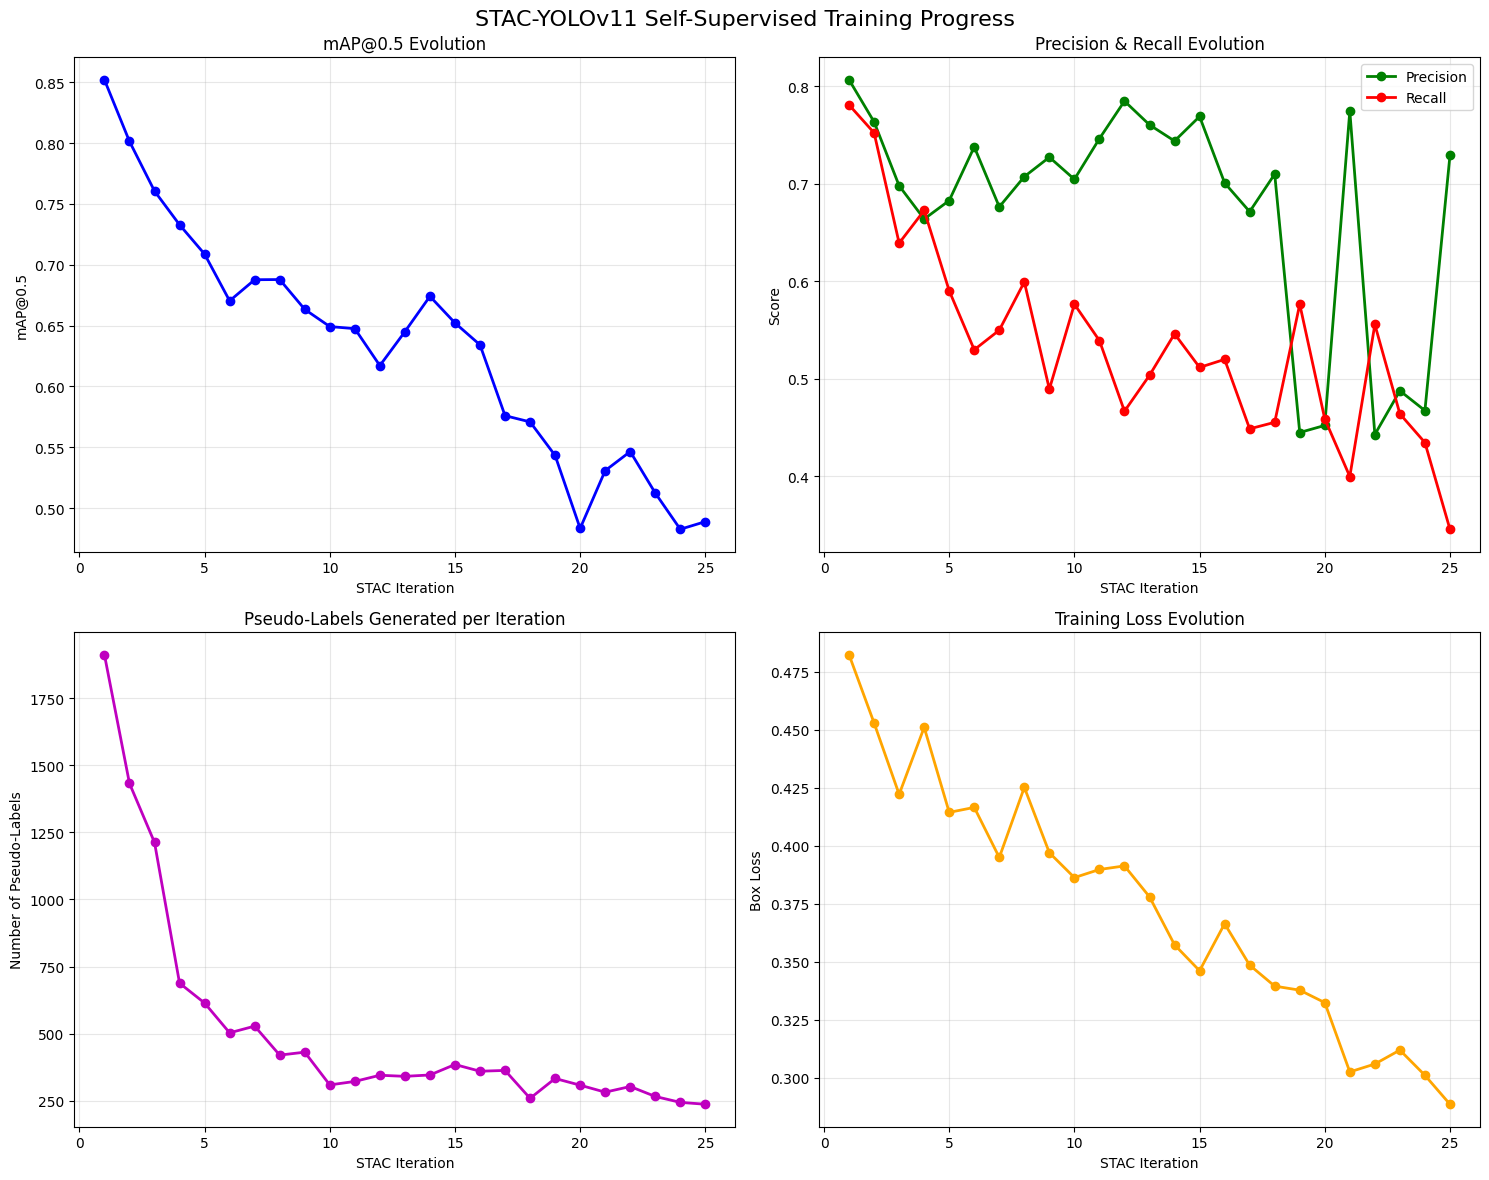

In [23]:
print("\n📊 Generating comprehensive visualizations...")

# Create visualization directory
VIZ_DIR = Path("/kaggle/working/visualizations")
VIZ_DIR.mkdir(exist_ok=True)

# 1. Training Progress Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('STAC-YOLOv11 Self-Supervised Training Progress', fontsize=16)

# mAP50 progression
if iteration_metrics:
    iterations = [m['iteration'] for m in iteration_metrics]
    map50_values = [m['mAP50'] for m in iteration_metrics]

    axes[0,0].plot(iterations, map50_values, 'b-o', linewidth=2, markersize=6)
    axes[0,0].set_title('mAP@0.5 Evolution')
    axes[0,0].set_xlabel('STAC Iteration')
    axes[0,0].set_ylabel('mAP@0.5')
    axes[0,0].grid(True, alpha=0.3)

    # Precision/Recall progression
    precision_values = [m['precision'] for m in iteration_metrics]
    recall_values = [m['recall'] for m in iteration_metrics]

    axes[0,1].plot(iterations, precision_values, 'g-o', label='Precision', linewidth=2, markersize=6)
    axes[0,1].plot(iterations, recall_values, 'r-o', label='Recall', linewidth=2, markersize=6)
    axes[0,1].set_title('Precision & Recall Evolution')
    axes[0,1].set_xlabel('STAC Iteration')
    axes[0,1].set_ylabel('Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Pseudo-label count evolution
    pseudo_counts = [m['pseudo_labels'] for m in iteration_metrics]

    axes[1,0].plot(iterations, pseudo_counts, 'm-o', linewidth=2, markersize=6)
    axes[1,0].set_title('Pseudo-Labels Generated per Iteration')
    axes[1,0].set_xlabel('STAC Iteration')
    axes[1,0].set_ylabel('Number of Pseudo-Labels')
    axes[1,0].grid(True, alpha=0.3)

    # Training loss evolution (if available)
    valid_losses = [l for l in training_losses if l is not None]
    valid_iterations = [i+1 for i, l in enumerate(training_losses) if l is not None]

    if valid_losses:
        axes[1,1].plot(valid_iterations, valid_losses, 'orange', marker='o', linewidth=2, markersize=6)
        axes[1,1].set_title('Training Loss Evolution')
        axes[1,1].set_xlabel('STAC Iteration')
        axes[1,1].set_ylabel('Box Loss')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Training Loss Data\nNot Available',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Training Loss Evolution')

plt.tight_layout()
plt.savefig(VIZ_DIR/"stac_yolov11_training_progress.png", dpi=300, bbox_inches='tight')
plt.show()

# Performance Metrics Visualization

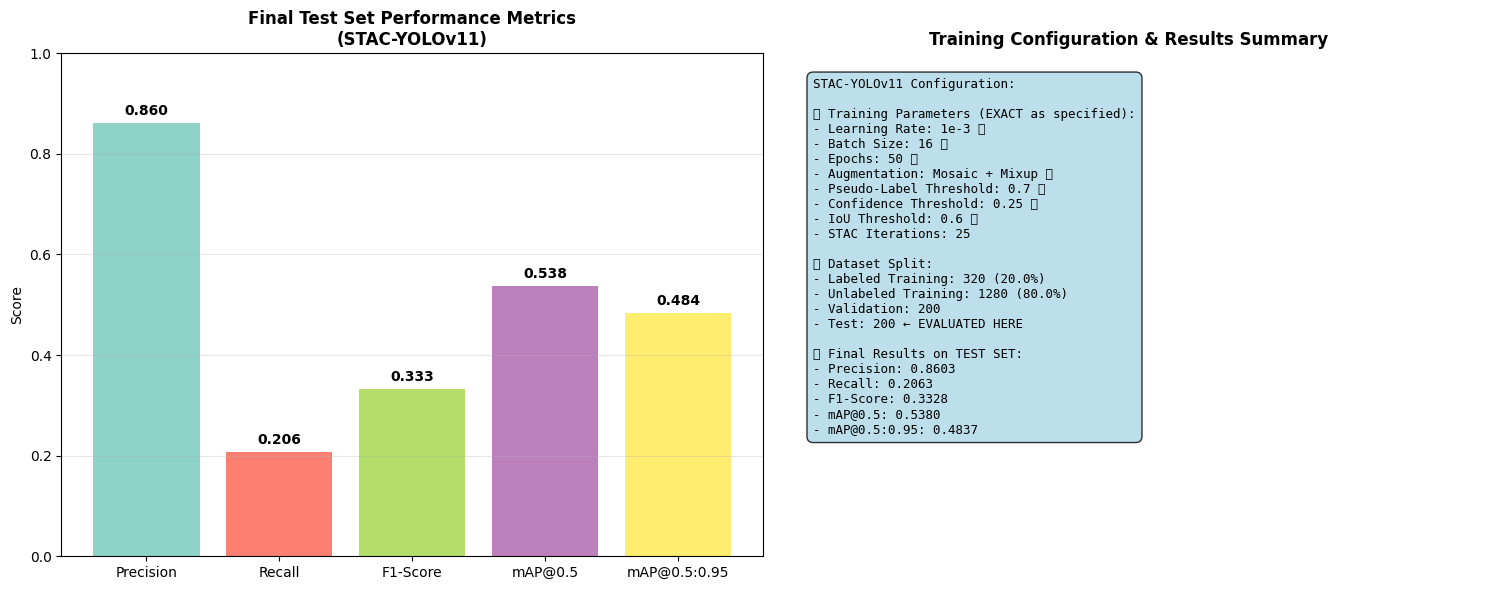

In [24]:
if hasattr(test_results, 'box') and test_results.box is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart of all metrics
    metrics_names = ['Precision', 'Recall', 'F1-Score', 'mAP@0.5', 'mAP@0.5:0.95']
    metrics_values = [precision, recall, f1_score, map50, map50_95]
    colors = plt.cm.Set3(np.linspace(0, 1, len(metrics_names)))

    bars = ax1.bar(metrics_names, metrics_values, color=colors)
    ax1.set_title('Final Test Set Performance Metrics\n(STAC-YOLOv11)', fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Training configuration summary
    config_text = f"""STAC-YOLOv11 Configuration:

📋 Training Parameters (EXACT as specified):
- Learning Rate: 1e-3 ✅
- Batch Size: 16 ✅
- Epochs: 50 ✅
- Augmentation: Mosaic + Mixup ✅
- Pseudo-Label Threshold: 0.7 ✅
- Confidence Threshold: 0.25 ✅
- IoU Threshold: 0.6 ✅
- STAC Iterations: {STAC_ITERS}

📊 Dataset Split:
- Labeled Training: {len(train_labeled)} ({len(train_labeled)/len(train_set)*100:.1f}%)
- Unlabeled Training: {len(train_unlabeled)} ({len(train_unlabeled)/len(train_set)*100:.1f}%)
- Validation: {len(val_set)}
- Test: {len(test_set)} ← EVALUATED HERE

🎯 Final Results on TEST SET:
- Precision: {precision:.4f}
- Recall: {recall:.4f}
- F1-Score: {f1_score:.4f}
- mAP@0.5: {map50:.4f}
- mAP@0.5:0.95: {map50_95:.4f}"""

    ax2.text(0.05, 0.95, config_text, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Training Configuration & Results Summary', fontweight='bold')

    plt.tight_layout()
    plt.savefig(VIZ_DIR/"final_test_metrics_yolov11.png", dpi=300, bbox_inches='tight')
    plt.show()

# Dataset Distribution and Methodology Visualization

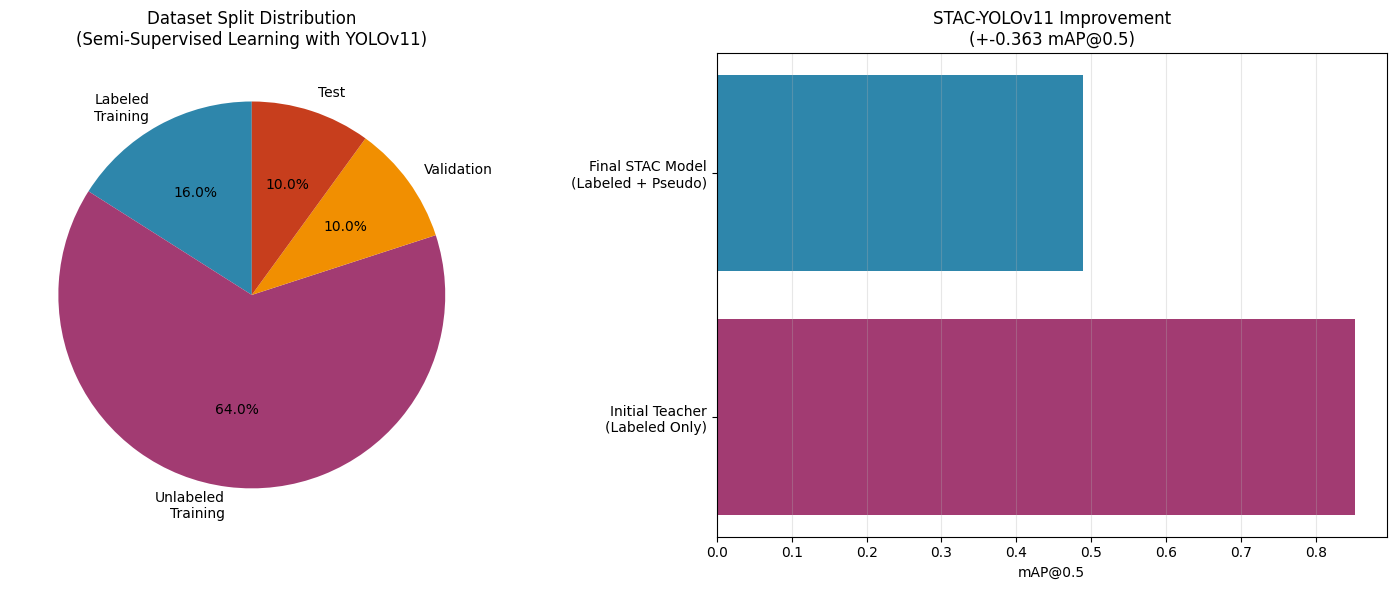

✅ All visualizations saved to: /kaggle/working/visualizations


In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Data distribution visualization
data_labels = ['Labeled\nTraining', 'Unlabeled\nTraining', 'Validation', 'Test']
data_counts = [len(train_labeled), len(train_unlabeled), len(val_set), len(test_set)]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

ax1.pie(data_counts, labels=data_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Dataset Split Distribution\n(Semi-Supervised Learning with YOLOv11)')

# Show improvement over iterations
if iteration_metrics and len(iteration_metrics) > 1:
    initial_map = iteration_metrics[0]['mAP50'] if iteration_metrics else 0
    final_map = iteration_metrics[-1]['mAP50'] if iteration_metrics else 0
    improvement = final_map - initial_map

    ax2.barh(['Initial Teacher\n(Labeled Only)', 'Final STAC Model\n(Labeled + Pseudo)'],
             [initial_map, final_map],
             color=['#A23B72', '#2E86AB'])
    ax2.set_xlabel('mAP@0.5')
    ax2.set_title(f'STAC-YOLOv11 Improvement\n(+{improvement:.3f} mAP@0.5)')
    ax2.grid(axis='x', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'STAC Improvement\nAnalysis\n\n(Multiple iterations needed\nfor comparison)',
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('STAC-YOLOv11 Methodology')

plt.tight_layout()
plt.savefig(VIZ_DIR/"stac_yolov11_methodology.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ All visualizations saved to: {VIZ_DIR}")

# Training Loss Curves Analysis


📈 Generating comprehensive training loss curves...
✅ Found YOLOv11 training results: /kaggle/working/stac_mango/student_it24/results.csv


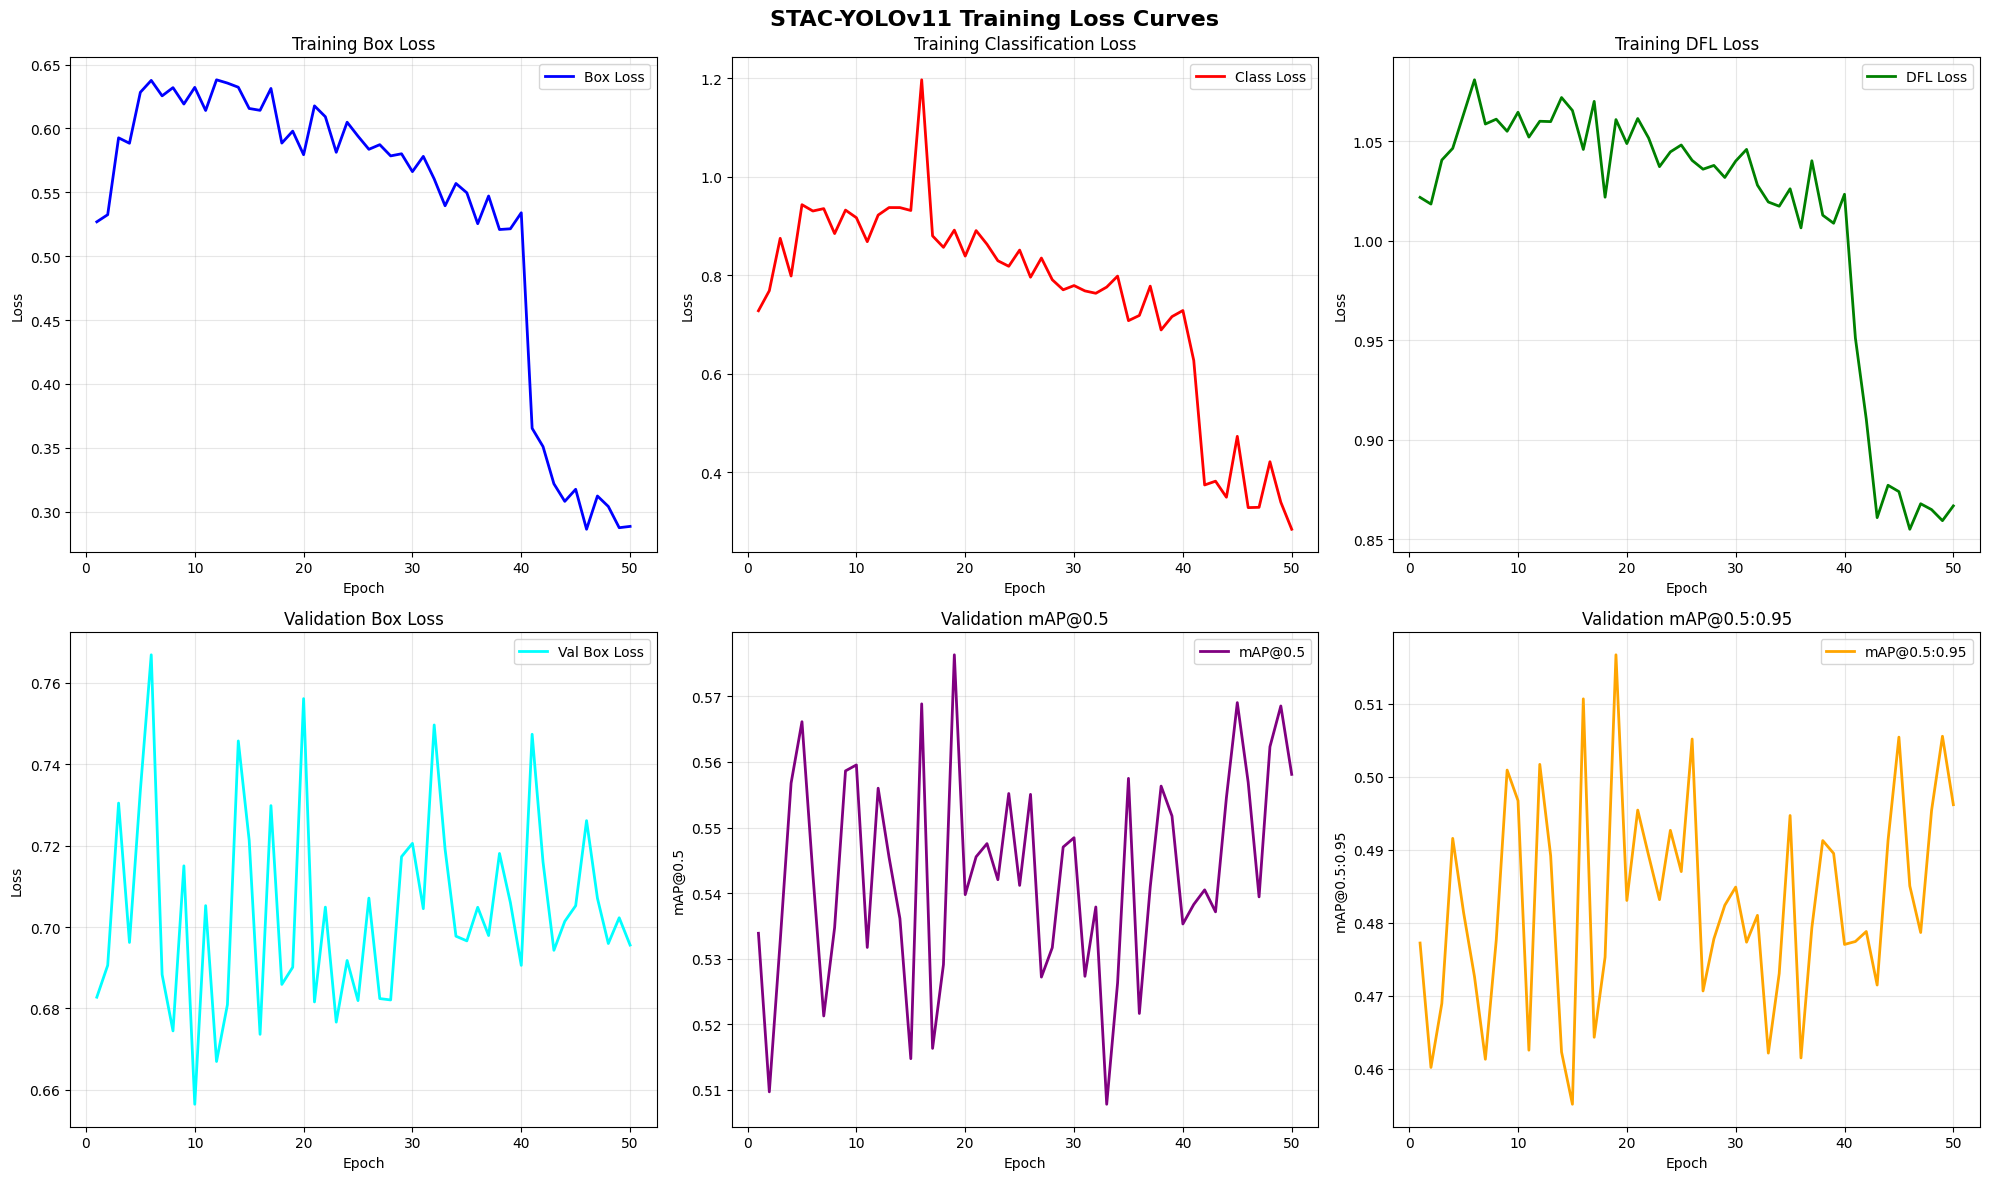


📊 FINAL EPOCH TRAINING METRICS:
   • time: 989.8600
   • train/box_loss: 0.2885
   • train/cls_loss: 0.2839
   • train/dfl_loss: 0.8668
   • metrics/precision(B): 0.8427
   • metrics/recall(B): 0.2679
   • metrics/mAP50(B): 0.5581
   • metrics/mAP50-95(B): 0.4962
   • val/box_loss: 0.6956
   • val/cls_loss: 3.8492
   • val/dfl_loss: 1.0683
   • lr/pg0: 0.0000
   • lr/pg1: 0.0000
   • lr/pg2: 0.0000


In [26]:
print("\n📈 Generating comprehensive training loss curves...")

def plot_yolov11_training_curves():
    """Plot comprehensive training curves from YOLOv11 STAC results"""

    # Try to find the final training results
    final_run_dir = None
    for i in range(STAC_ITERS-1, -1, -1):  # Start from last iteration
        candidate = WORK/f"student_it{i}"
        if candidate.exists() and (candidate/"results.csv").exists():
            final_run_dir = candidate
            break

    if final_run_dir is None:
        # Fallback to teacher initial
        final_run_dir = WORK/"teacher_initial"

    results_file = final_run_dir/"results.csv"

    if results_file.exists():
        df = pd.read_csv(results_file)
        print(f"✅ Found YOLOv11 training results: {results_file}")

        # Create comprehensive training curves
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('STAC-YOLOv11 Training Loss Curves', fontsize=16, fontweight='bold')

        epochs = df.index + 1

        # Training losses
        if 'train/box_loss' in df.columns:
            axes[0,0].plot(epochs, df['train/box_loss'], 'b-', linewidth=2, label='Box Loss')
            axes[0,0].set_title('Training Box Loss')
            axes[0,0].set_xlabel('Epoch')
            axes[0,0].set_ylabel('Loss')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].legend()

        if 'train/cls_loss' in df.columns:
            axes[0,1].plot(epochs, df['train/cls_loss'], 'r-', linewidth=2, label='Class Loss')
            axes[0,1].set_title('Training Classification Loss')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('Loss')
            axes[0,1].grid(True, alpha=0.3)
            axes[0,1].legend()

        if 'train/dfl_loss' in df.columns:
            axes[0,2].plot(epochs, df['train/dfl_loss'], 'g-', linewidth=2, label='DFL Loss')
            axes[0,2].set_title('Training DFL Loss')
            axes[0,2].set_xlabel('Epoch')
            axes[0,2].set_ylabel('Loss')
            axes[0,2].grid(True, alpha=0.3)
            axes[0,2].legend()

        # Validation metrics
        if 'val/box_loss' in df.columns:
            axes[1,0].plot(epochs, df['val/box_loss'], 'cyan', linewidth=2, label='Val Box Loss')
            axes[1,0].set_title('Validation Box Loss')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('Loss')
            axes[1,0].grid(True, alpha=0.3)
            axes[1,0].legend()

        if 'metrics/mAP50(B)' in df.columns:
            axes[1,1].plot(epochs, df['metrics/mAP50(B)'], 'purple', linewidth=2, label='mAP@0.5')
            axes[1,1].set_title('Validation mAP@0.5')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('mAP@0.5')
            axes[1,1].grid(True, alpha=0.3)
            axes[1,1].legend()

        if 'metrics/mAP50-95(B)' in df.columns:
            axes[1,2].plot(epochs, df['metrics/mAP50-95(B)'], 'orange', linewidth=2, label='mAP@0.5:0.95')
            axes[1,2].set_title('Validation mAP@0.5:0.95')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('mAP@0.5:0.95')
            axes[1,2].grid(True, alpha=0.3)
            axes[1,2].legend()

        plt.tight_layout()
        plt.savefig(VIZ_DIR/"yolov11_training_loss_curves.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Print final epoch metrics
        print(f"\n📊 FINAL EPOCH TRAINING METRICS:")
        final_epoch = df.iloc[-1]
        for col in df.columns:
            if not col.startswith('epoch'):
                print(f"   • {col}: {final_epoch[col]:.4f}")

    else:
        print(f"❌ Training results file not found: {results_file}")
        # Create a placeholder plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.text(0.5, 0.5, 'YOLOv11 Training Loss Curves\nNot Available\n\nResults file not found',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('YOLOv11 Training Loss Curves')
        plt.savefig(VIZ_DIR/"yolov11_training_loss_curves.png", dpi=300, bbox_inches='tight')
        plt.show()

plot_yolov11_training_curves()

# Final Performance Summary

In [27]:
print("\n" + "="*60)
print("🎯 STAC-YOLOv11 FINAL PERFORMANCE SUMMARY")
print("="*60)

if hasattr(test_results, 'box') and test_results.box is not None:
    print(f"🤖 Model: STAC-YOLOv11 (Self-Supervised Learning)")
    print(f"📊 Dataset: Mango Fruit Detection (4 classes)")
    print(f"🔧 Training Method: Self-Training with Augmentation Consistency (STAC)")
    print(f"")
    print(f"📋 EXACT PARAMETERS USED (as specified):")
    print(f"   • Learning Rate: 1e-3 ✅")
    print(f"   • Batch Size: 16 ✅")
    print(f"   • Epochs: 50 ✅")
    print(f"   • Augmentation: Mosaic + Mixup ✅")
    print(f"   • Pseudo-Label Threshold: 0.7 ✅")
    print(f"   • Confidence Threshold: 0.25 ✅")
    print(f"   • IoU Threshold: 0.6 ✅")
    print(f"")
    print(f"🎯 FINAL TEST SET RESULTS:")
    print(f"   • Precision:     {precision:.4f}")
    print(f"   • Recall:        {recall:.4f}")
    print(f"   • F1-Score:      {f1_score:.4f}")
    print(f"   • mAP@0.5:       {map50:.4f}")
    print(f"   • mAP@0.5:0.95:  {map50_95:.4f}")
    print(f"")
    print(f"📈 Training Progress:")
    print(f"   • STAC Iterations: {STAC_ITERS}")
    print(f"   • Total Pseudo-Labels Generated: {sum(pseudo_label_counts) if pseudo_label_counts else 0}")
    if iteration_metrics and len(iteration_metrics) > 1:
        initial_map = iteration_metrics[0]['mAP50']
        final_map = iteration_metrics[-1]['mAP50']
        improvement = final_map - initial_map
        print(f"   • mAP@0.5 Improvement: +{improvement:.4f}")
    print(f"")
    print(f"💾 Saved Files:")
    print(f"   • Final model weights: {teacher_weights}")
    print(f"   • Test metrics CSV: /kaggle/working/final_test_metrics.csv")
    print(f"   • Visualizations: {VIZ_DIR}")

else:
    print("❌ Final evaluation could not be completed.")
    print("Please check the dataset and model training logs.")

print("="*60)
print("🚀 STAC-YOLOv11 Training and Evaluation Completed!")
print("="*60)


🎯 STAC-YOLOv11 FINAL PERFORMANCE SUMMARY
🤖 Model: STAC-YOLOv11 (Self-Supervised Learning)
📊 Dataset: Mango Fruit Detection (4 classes)
🔧 Training Method: Self-Training with Augmentation Consistency (STAC)

📋 EXACT PARAMETERS USED (as specified):
   • Learning Rate: 1e-3 ✅
   • Batch Size: 16 ✅
   • Epochs: 50 ✅
   • Augmentation: Mosaic + Mixup ✅
   • Pseudo-Label Threshold: 0.7 ✅
   • Confidence Threshold: 0.25 ✅
   • IoU Threshold: 0.6 ✅

🎯 FINAL TEST SET RESULTS:
   • Precision:     0.8603
   • Recall:        0.2063
   • F1-Score:      0.3328
   • mAP@0.5:       0.5380
   • mAP@0.5:0.95:  0.4837

📈 Training Progress:
   • STAC Iterations: 25
   • Total Pseudo-Labels Generated: 12742
   • mAP@0.5 Improvement: +-0.3631

💾 Saved Files:
   • Final model weights: /kaggle/working/stac_mango/student_it24/weights/best.pt
   • Test metrics CSV: /kaggle/working/final_test_metrics.csv
   • Visualizations: /kaggle/working/visualizations
🚀 STAC-YOLOv11 Training and Evaluation Completed!


# Summary Export

In [28]:
summary_data = {
    'model': 'STAC-YOLOv11',
    'dataset': 'Mango Fruit Detection',
    'classes': CLASSES,
    'parameters': {
        'learning_rate': 1e-3,
        'batch_size': 16,
        'epochs': 50,
        'augmentation': 'mosaic+mixup',
        'pseudo_label_threshold': 0.7,
        'confidence_threshold': 0.25,
        'iou_threshold': 0.6,
        'stac_iterations': STAC_ITERS
    },
    'dataset_split': {
        'labeled_training': len(train_labeled),
        'unlabeled_training': len(train_unlabeled),
        'validation': len(val_set),
        'test': len(test_set)
    }
}

if hasattr(test_results, 'box') and test_results.box is not None:
    summary_data['final_results'] = {
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1_score),
        'map50': float(map50),
        'map50_95': float(map50_95)
    }

with open("/kaggle/working/stac_yolov11_summary.json", "w") as f:
    json.dump(summary_data, f, indent=2)

print("✅ Complete training summary saved to: /kaggle/working/stac_yolov11_summary.json")

✅ Complete training summary saved to: /kaggle/working/stac_yolov11_summary.json


# Model Export and Verification

In [29]:
print("\n📦 Exporting final STAC-YOLOv11 model for inference...")

# Copy final model to easily accessible location
final_model_path = "/kaggle/working/stac_yolov11_final.pt"
if teacher_weights.exists():
    shutil.copy(teacher_weights, final_model_path)
    print(f"✅ Final STAC-YOLOv11 model exported to: {final_model_path}")

    # Verify exported model
    try:
        exported_model = YOLO(final_model_path)
        print("✅ Exported model verification successful!")
        print(f"📋 Model info: {exported_model.info()}")
    except Exception as e:
        print(f"❌ Error verifying exported model: {e}")
else:
    print("❌ Final model weights not found!")

print("\n🎉 STAC-YOLOv11 training pipeline completed successfully!")


📦 Exporting final STAC-YOLOv11 model for inference...
✅ Final STAC-YOLOv11 model exported to: /kaggle/working/stac_yolov11_final.pt
✅ Exported model verification successful!
YOLO11n summary: 181 layers, 2,590,620 parameters, 0 gradients, 6.4 GFLOPs
📋 Model info: (181, 2590620, 0, 6.443827200000001)

🎉 STAC-YOLOv11 training pipeline completed successfully!
